In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mutual_info_score, roc_auc_score

from xgboost.sklearn import XGBRegressor
import scipy.stats as st
from sklearn.model_selection import GridSearchCV
import seaborn as sns


In [4]:
# set the file name (required)
__file__ = 'Part2.ipynb'

# add ipython magics
import ipytest.magics

import pytest

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

In [6]:
def plot(df3):
  total_len = len(df3.columns)
  fig = plt.figure(figsize=(400,400))
  '''
  plt.subplot(3, 3, 1)
  plt.plot(df3.index, df3[df3.columns[99]], '-' )

  plt.subplot(3, 3, 2)
  plt.plot(df3.index, df3[df3.columns[100]], '-' )

  plt.subplot(3, 3, 3)
  plt.plot(df3.index, df3[df3.columns[34]], '-' )
  plt.subplot(3, 3, 4)
  plt.plot(df3.index, df3[df3.columns[89]], '-' )
  plt.show()
  '''

  for i in range(1,total_len+1):
      plt.subplot(total_len, total_len, i)
      plt.plot(df3.index, df3[df3.columns[i-1]], '-')
      plt.axis('off')
  plt.savefig('gife.png')
  plt.show()

In [7]:
def algorithm(X_train, X_test, y_train, y_test):
  clf_dt = tree.DecisionTreeClassifier()
  clf_dt.fit(X_train, y_train)
  
  predicted_y = clf_dt.predict(X_test)
  clf_dt.score(X_test, y_test)
  
  mutual_score = mutual_info_score(y_test, predicted_y)
  roc_score2 = roc_auc_score(y_test, predicted_y)
  
  X_train['Unnamed: 5'] = X_train['Unnamed: 5'].astype(float)
  X_train['Unnamed: 6'] = X_train['Unnamed: 6'].astype(float)
  X_test['Unnamed: 5'] = X_test['Unnamed: 5'].astype(float)
  X_test['Unnamed: 6'] = X_test['Unnamed: 6'].astype(float)
  
  
  print('mutual score = ',mutual_score)
  print('roc_auc_score = ', roc_score2)
  return mutual_score, roc_score2

In [8]:
def xgboost_( X_train, X_test, y_train, y_test):
  params = {  
    'max_depth': [5,10,15],
    'n_estimators': [50,100,150]
  }

  xr = XGBRegressor() 

  gs = GridSearchCV(xr, params, n_jobs=1,verbose=1)  
  gs.fit(X_train, y_train)  
  gs.best_params_
  
  xgb_predict = gs.predict(X_test)
  
  
  xg_pre = []
  for i in range(len(xgb_predict)):
    if xgb_predict[i]>0.49:
      xg_pre.append(1)
    else:
      xg_pre.append(0)
      
  xg_pre = np.array(xg_pre)
  score1 = gs.score(X_test, y_test)
  xg_roc = roc_auc_score(y_test, xg_pre)
  print('xgboost : ', score1)
  print('xgboost roc :', xg_roc)
  return score1, xg_roc

In [2]:
def work_(data):
  #print(type(data))
  df = pandas.read_excel(data)
  new_df = df.filter(['Unnamed: 5','Unnamed: 6'], axis=1)
  new_df.replace(np.nan, 0, inplace=True)
  df.replace(np.nan, 0, inplace=True)
  
  f2008 = list(new_df['Unnamed: 5'])
  f2009 = list(new_df['Unnamed: 6'])
  
  percent_growth = []
  target = []
  for i in range(1,len(f2008)):
      if f2009[i] == 0:
          percent_growth.append(-9999)
          target.append(0)
          continue
      growth = (f2009[i]-f2008[i])/f2009[i]
      percent_growth.append(growth*100)
      if growth > 0:
          target.append(1)
      else:
          target.append(0)
  
  new_df.drop('Index Number', inplace=True)
  new_df['% growth'] = percent_growth
  new_df['target'] = target
  
  df2 = df.drop(['PROGRAM', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'FUNDING' ], axis=1)
  df2.drop('Index Number', inplace=True)
  
  
  df3 = pandas.DataFrame({col: df2[col].astype('category').cat.codes for col in df2}, index=df2.index)
  
  df3.reset_index(drop=True,inplace=True)
  new_df.reset_index(drop=True,inplace=True)
  
  df4 = pandas.concat([df3, new_df], axis=1)
  
  features = df4.drop('target', axis=1)
  labels = df4['target']
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)
  #------------------------------------------------------------------------------------------------------------------------------------
  df = pandas.read_excel("2010 Federal STEM Education Inventory Data Set.xls", skiprows = 1)
  cols = [column for column in df.columns if "Unnamed" not in column]
  df = df[cols]
  df = df.dropna(subset = ('C2) Funding FY2009', 'C1) Funding FY2008'), axis = 0)
  df['Growth'] = ((df['C2) Funding FY2009'] - df['C1) Funding FY2008']) / df['C1) Funding FY2008']) * 100
  df['target'] = (df['Growth'] >= 0).astype(int)
  funding_cols = ['C1) Funding FY2008', 'C2) Funding FY2009', 'C3) Funding FY2010']
  df_non_funding = df.drop(funding_cols, axis = 1)
  cols = df_non_funding.columns[df_non_funding.isnull().sum() < 50]
  df_nf = df_non_funding[cols]
  
  fig = plt.figure(figsize=(10,6))
  sns.countplot(x="Agency", data = df_nf)
  plt.ylabel('Frequency', fontsize=12)
  plt.xlabel('Types of Agency', fontsize=12)
  plt.xticks(rotation='vertical')
  plt.title("Frequency of Agency types", fontsize=15)
  plt.show()
  
  fig = plt.figure(figsize=(15,10))
  sns.countplot(x="Subagency", data = df_nf)
  plt.ylabel('Frequency', fontsize=12)
  plt.xlabel('Types of Subagency', fontsize=12)
  plt.xticks(rotation='vertical')
  plt.title("Frequency of Subagency types", fontsize=15)
  plt.show()
  
  fig = plt.figure(figsize=(15,10))
  sns.countplot(x = "B) Year Established", data = df_nf)
  plt.ylabel('Frequency', fontsize=12)
  plt.xlabel('Year Established', fontsize=12)
  plt.xticks(rotation='vertical')
  plt.title("Frequency of Year Established", fontsize=15)
  plt.show()
  #--------------------------------------------------------------------------------------------------------------------------------------
  #plot(df3)
  score1, roc = algorithm( X_train, X_test, y_train, y_test)
  score2, xg_roc = xgboost_( X_train, X_test, y_train, y_test)
  
  return score1, score2, roc, xg_roc
  

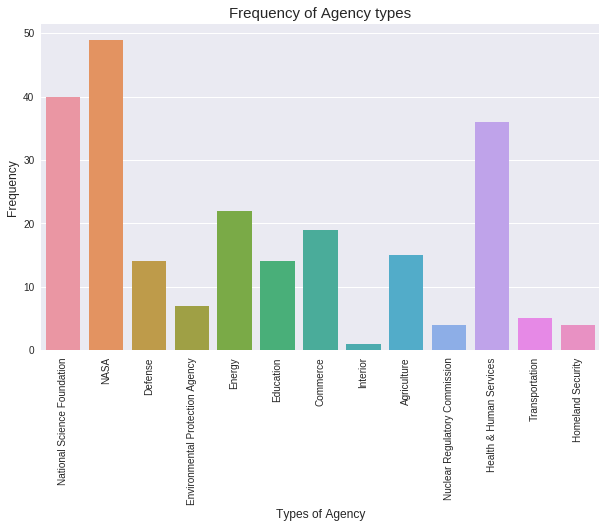

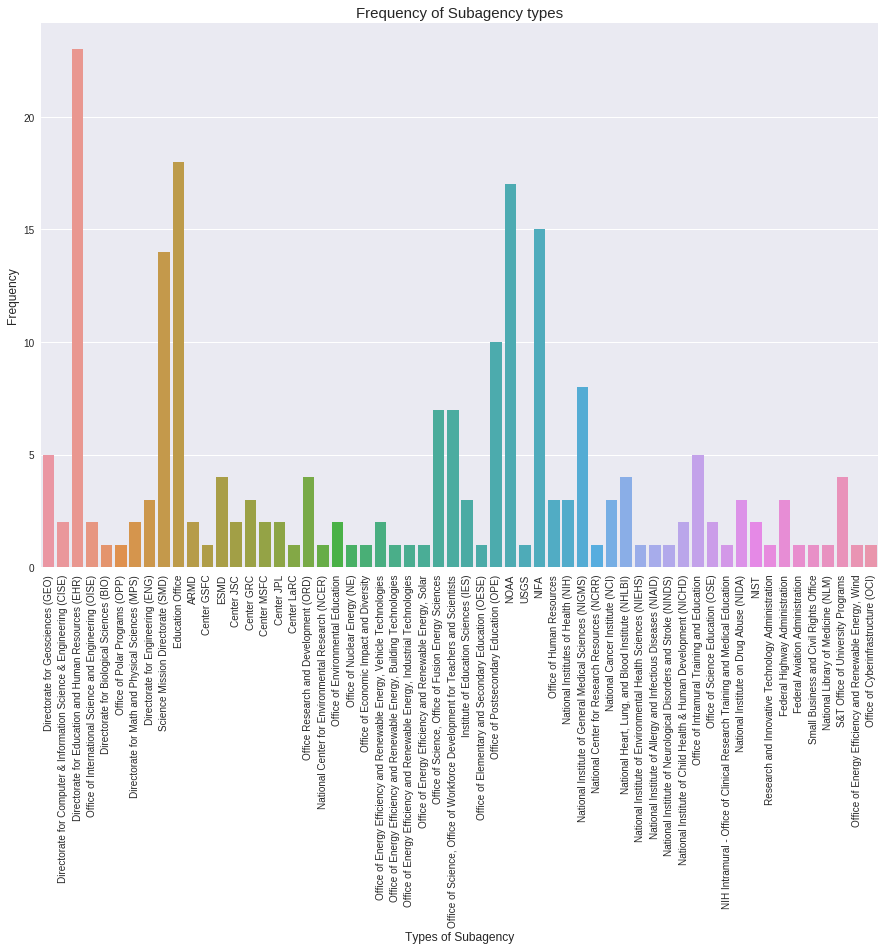

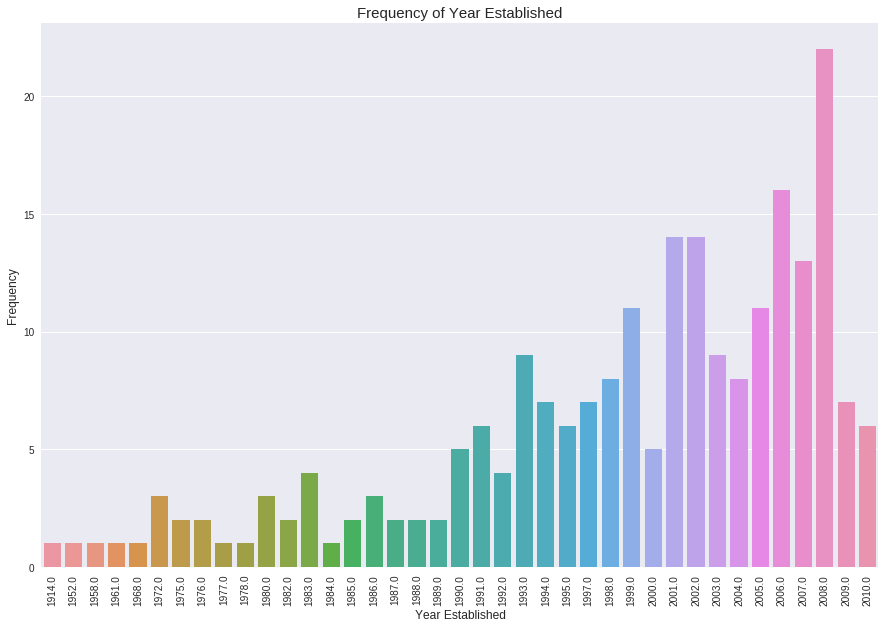

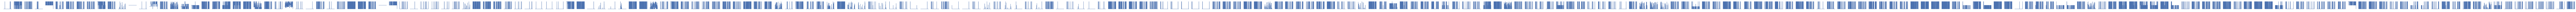

mutual score =  0.6931471805599454
roc_auc_score =  1.0
Fitting 3 folds for each of 9 candidates, totalling 27 fits
xgboost :  0.9999695107262364
xgboost roc : 1.0


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.4s finished


(0.6931471805599454, 0.9999695107262364, 1.0, 1.0)

In [44]:
data = '2010 Federal STEM Education Inventory Data Set.xls'
work_(data)

In [9]:
%%run_pytest[clean]


def test_work_(data = '2010 Federal STEM Education Inventory Data Set.xls'):
  #print(type(data))
  df = pandas.read_excel(data)
  new_df = df.filter(['Unnamed: 5','Unnamed: 6'], axis=1)
  new_df.replace(np.nan, 0, inplace=True)
  df.replace(np.nan, 0, inplace=True)
  
  f2008 = list(new_df['Unnamed: 5'])
  f2009 = list(new_df['Unnamed: 6'])
  
  percent_growth = []
  target = []
  for i in range(1,len(f2008)):
      if f2009[i] == 0:
          percent_growth.append(-9999)
          target.append(0)
          continue
      growth = (f2009[i]-f2008[i])/f2009[i]
      percent_growth.append(growth*100)
      if growth > 0:
          target.append(1)
      else:
          target.append(0)
  
  new_df.drop('Index Number', inplace=True)
  new_df['% growth'] = percent_growth
  new_df['target'] = target
  
  df2 = df.drop(['PROGRAM', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'FUNDING' ], axis=1)
  df2.drop('Index Number', inplace=True)
  
  
  df3 = pandas.DataFrame({col: df2[col].astype('category').cat.codes for col in df2}, index=df2.index)
  
  df3.reset_index(drop=True,inplace=True)
  new_df.reset_index(drop=True,inplace=True)
  
  df4 = pandas.concat([df3, new_df], axis=1)
  
  features = df4.drop('target', axis=1)
  labels = df4['target']
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30)
  
  #plot(df3)
  score1, roc = algorithm( X_train, X_test, y_train, y_test)
  score2, xg_roc = xgboost_( X_train, X_test, y_train, y_test)
  assert score1 > 0.50
  assert roc > 0.80
  assert score2 > 0.50
  assert xg_roc > 0.80


============================= test session starts =============================
platform win32 -- Python 3.5.2, pytest-2.9.1, py-1.4.31, pluggy-0.3.1
rootdir: D:\Python Coding\Internship\RedCarpet\ml_stem_analysis, inifile: 
collected 1 items

Part2.py .

========================== 1 passed in 10.01 seconds ==========================
